# Formula

The loss function of SVM is as follows:
\begin{align}
L(w) = \frac{1}{2}||w||^2 + C\Sigma_{i=1}^{N}max(0, 1-y_iwx)
\end{align}

The derivative of max component:


* if $1-y_i(wx_i +b) >0$, max function equals $1-y_i(wx_i +b)$ and the derivate equals $-y_ix_i$
* if $1-y_i(wx_i +b) <=0$, max function equals 0 and the derivative equals 0



Update parameter with gradient descent is as follows:
\begin{align}
w = w - lr(w-C\Sigma_{i=1}^{N}\delta_i y_i x_i)
\end{align}

The sample used in Notebook is MNIST. Student need to practice with other dataset like Iris, CIFAR, CIFAR100 to compare and write report for the practice session.

# SVM from scratch (Linear SVM)

In [2]:
import numpy as np

In [3]:
#@title Hard margin SVM

class HardMarginSVM:
    def __init__(self, learning_rate=0.001, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            for i in range(n_samples):
                condition = y[i] * (np.dot(X[i], self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (self.weights) # only update by lr
                else:
                    self.weights -= self.lr * (self.weights - np.dot(X[i], y[i]))
                    self.bias -= self.lr * y[i]

    def predict(self, X):
        linear_output = np.dot(X, self.weights) - self.bias
        return np.sign(linear_output)

# Create example data
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
y = np.array([1, 1, 1, -1, -1, -1])

# Training with hard margin SVM
svm = HardMarginSVM()
svm.fit(X, y)

# Predictions
predictions = svm.predict(X)
print("Predict:", predictions)

Predict: [ 1.  1. -1. -1. -1. -1.]


In [4]:
X.shape, y.shape

((6, 2), (6,))

In [5]:
#@title Soft margin SVM

class SoftMarginSVM:
    def __init__(self, learning_rate=0.001, C=1.0, n_iterations=1000):
        self.lr = learning_rate
        self.C = C
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            for i in range(n_samples):
                condition = y[i] * (np.dot(X[i], self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.C * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.C * self.weights - np.dot(X[i], y[i]))
                    self.bias -= self.lr * y[i]

    def predict(self, X):
        linear_output = np.dot(X, self.weights) - self.bias
        return np.sign(linear_output)

X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]])
y = np.array([1, 1, 1, -1, -1, -1])

svm = SoftMarginSVM(C=0.1)
svm.fit(X, y)

predictions = svm.predict(X)
print("Predict:", predictions)


Predict: [ 1.  1. -1. -1. -1. -1.]


# Mnist classification + SVM Sklearn

In [6]:
#@title Load Required Libraries

from torchvision import datasets # MNIST datasets
from torchvision.transforms import ToTensor # transform PIL image to torch.Tensor

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from pathlib import Path
from googledrivedownloader import download_file_from_google_drive

## Prepare data

In [7]:
# Loading Kaggle MNIST data from drive

TRAIN_PATH = 'khmt/mnist_train.zip'
if not Path(TRAIN_PATH).is_file():
    download_file_from_google_drive(
        file_id='1c6CDZR6q5wAyqcvCX-XCmcbJmQ5D5Ydv',
        dest_path=TRAIN_PATH,
)

TEST_PATH = 'khmt/mnist_test.zip'
if not Path(TEST_PATH).is_file():
    download_file_from_google_drive(
        file_id='1G2FwNi1UEe47AMfXSWr4cYprNVOVEgNQ',
        dest_path=TEST_PATH,
)

In [8]:
# # unzip data
# !unzip khmt/mnist_train.zip
# !unzip khmt/mnist_test.zip
import zipfile

# Unzip training data
with zipfile.ZipFile('khmt/mnist_train.zip', 'r') as zip_ref:
    zip_ref.extractall('khmt')

# Unzip test data
with zipfile.ZipFile('khmt/mnist_test.zip', 'r') as zip_ref:
    zip_ref.extractall('khmt')


In [9]:
train = pd.read_csv('khmt/mnist_train.csv')
test = pd.read_csv('khmt/mnist_test.csv')

#train.head()
print(train.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


In [10]:
len(train), len(test)

(60000, 10000)

In [11]:
# Shuffeling training data
train_shuffled = shuffle(train.values, random_state=0)

# Extracting features as X and labels as y
# X_train = train.drop(labels = ["label"],axis = 1)
X_train = train.drop(labels = ["label"],axis = 1)
y_train = train["label"]

# Loading test data (no labels are provieded)
# X_test = test.values
X_test = test.drop(labels = ["label"],axis = 1)
y_test = test["label"]

print(f'X_train = {X_train.shape}, y = {y_train.shape}, X_test = {X_test.shape}')

X_train = (60000, 784), y = (60000,), X_test = (10000, 784)


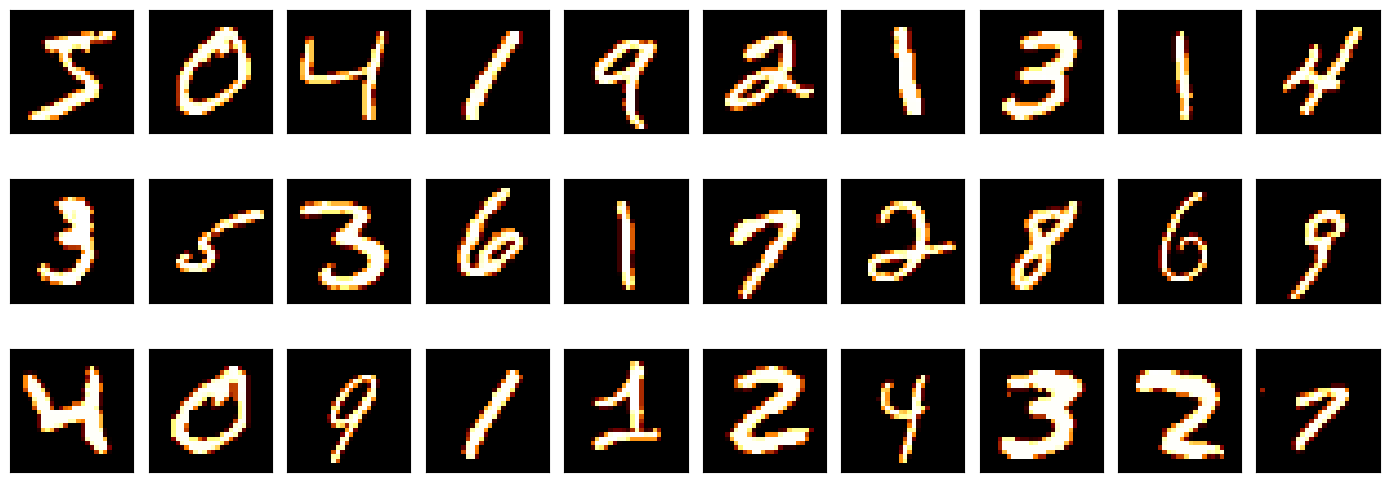

In [12]:
# Plotting some digits

plt.figure(figsize=(14,12))
for digit_num in range(0,30):
    plt.subplot(7,10,digit_num+1)
    grid_data = X_train.iloc[digit_num].values.reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [13]:
# Normalizing data .. Normilization was found better in this dataset than Standardization
# Normilization between (0, 1) was tested vs (-1, 1) and (-1, 1) showed better results

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
normalized_X_train = scaler.transform(X_train)
normalized_X_test = scaler.transform(X_test)

In [ ]:
# # Finding best gamma and C for RBF kernel (not recommended to re-run as it consumes too much time)
# # Result: gamma =  0.00728932024638, C = 2.82842712475

# %%time

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
# C_range = np.logspace(-2, 2, 10)
# gamma_range = np.logspace(-2, 2, 10)
# param_grid = dict(gamma=gamma_range, C=C_range)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf'] }
cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(normalized_X_train, y_train)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

![alt text](https://scikit-learn.org/dev/_images/sphx_glr_plot_rbf_parameters_002.png)


```
The best parameters are {'C': 2.82842712475, 'gamma': 0.00728932024638} with a score of 0.97
```



## Training

In [14]:
#@title Dimensionality Reduction with PCA (Principal Component Analysis)

pca = PCA(n_components=0.90)
pca_X_train = pca.fit_transform(normalized_X_train)
pca_X_test = pca.transform(normalized_X_test)
print(f'{pca.explained_variance_} \n Number of PCA Vectors = {len(pca.explained_variance_)}' )

[20.46749228 14.96556378 13.01083442 11.36648413 10.2684713   9.09465393
  6.90062023  6.08224197  5.82522144  4.97100058  4.4483582   4.26656256
  3.61872383  3.56872543  3.32941238  3.12760221  2.7935477   2.69302437
  2.50398124  2.43105249  2.24858392  2.12319586  2.01112188  1.92458865
  1.86313316  1.77015514  1.71375883  1.6584752   1.57066972  1.45704763
  1.38794441  1.36696795  1.2709374   1.23712388  1.20219636  1.14653124
  1.06672222  1.02891224  1.01535266  0.99602734  0.96329648  0.93817581
  0.88263497  0.83985104  0.81192584  0.79110695  0.76349025  0.74151934
  0.71719569  0.67884571  0.67281904  0.65971735  0.62423857  0.60941628
  0.59924182  0.57246865  0.56843079  0.54512837  0.53521209  0.5162525
  0.50723676  0.50461442  0.48594029  0.46721959  0.45074549  0.43704587
  0.42822471  0.41502197  0.40673362  0.39783303  0.39434185  0.38191103
  0.37448541  0.36886675  0.34959065  0.34565866  0.34053031  0.32714647
  0.31132144  0.30196386  0.29968241  0.29769785  0.

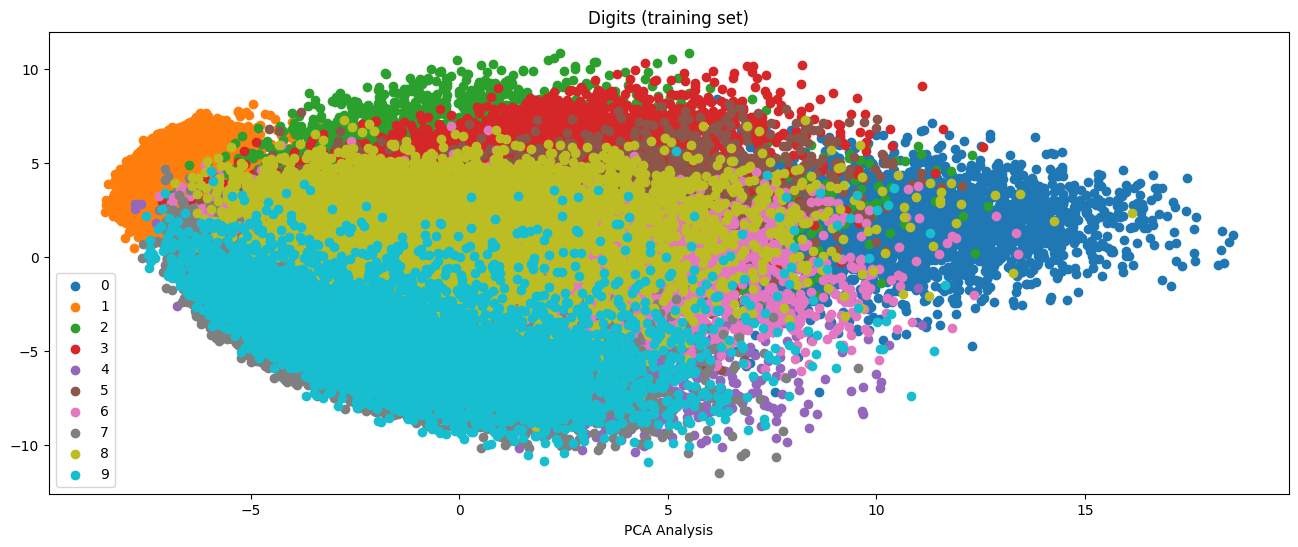

In [15]:
# Plotting PCA output
f, ax = plt.subplots(1, 1)
for i in range(10):
    ax.scatter(pca_X_train[y_train == i, 0], pca_X_train[y_train == i, 1], label=i)
ax.set_xlabel("PCA Analysis")
ax.legend()
f.set_size_inches(16, 6)
ax.set_title("Digits (training set)")
plt.show()

In [16]:
# Trainging the SVC model with gamma and C found in previous step

# classifier = svm.SVC(gamma=0.00728932024638, C=2.82842712475) # best parameters
classifier = svm.SVC(verbose=1)
classifier.fit(pca_X_train, y_train)

# Calculating the training accuracy (to measure the bias)
train_accuracy = classifier.score(pca_X_train, y_train)
print (f"Training Accuracy: {train_accuracy*100:.3f}%")

# Getting predictions
predictions = classifier.predict(pca_X_test)

[LibSVM]Training Accuracy: 99.260%


In [17]:
from sklearn.metrics import classification_report

y_test = test["label"]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

